In [2]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
import krotov
from krotov.second_order import _overlap # state overlap function

# Initialize parameters

We initialize the simulation parameters according to the paper. The field dimensions where chosoen to prevent wrap-around effects during the simulation. Coupling rates are values typically found in state-off-the-art membrane-in-the-middle optomechanical systems.

In [324]:
# occupancies
Nd = 4 # Hilbert dimension of cavity field
Nb = 30 # Hilbert dimension of mechanical field
nth = 2 # thermal phonon occpancy of mechanical bath

# coupling rates
Gamma_m = 2 * np.pi * 3 # mechanical linewidth, angular freq units
kappa = 2*np.pi* 450000 # cavity linewidth, angular freq units

cooperativity = 100 #optomechanical cooperativity
ratio = 0.7         # ratio of blue pump coupling to red pump coupling
Gminus0 = np.sqrt(cooperativity * Gamma_m * kappa /4) #initial cavity-enhanced coupling for red pump, angular freq units
Gplus0 = ratio * Gminus0     #initial cavity-enhanced coupling for blue pump, angular freq units

# Initialize the Liouvillian

Talk abut using RWA. Need to define Lindblad operators properly

In [325]:
def Liouvillian(Nd = 4, Nb = 40, nth = 0, Gamma_m = 1, kappa = 1e6, Gminus0 = 1e4, Gplus0 = 1e3):
    '''
    Defines the Liovillian qutip object which will govern time evolution of the optomechanical.
    
    Args:
        Nd: Hilbert dimension of cavity field
        Nb: Hilbert dimension of mechanical field
        nth: thermal phonon occpancy of mechanical bath
        Gamma_m: mechanical linewidth, angular freq units
        kappa: cavity linewidth, angular freq units
        Gminus0: initial cavity-enhanced coupling for red pump, angular freq units
        Gplus0: initial cavity-enhanced coupling for blue pump, angular freq units
        
    Returns:
        Liouvillian object
    '''
    
    # define red and blue coupling coefficients
    eps_minus = lambda t, args: Gminus0
    eps_plus = lambda t, args: Gplus0
    
    # single-sided beam-splitter and two-mode squeezing terms
    Hbs1 = qt.tensor(-qt.create(Nd), qt.destroy(Nb)) # BS: cavity excitation term
    Hbs2 = Hbs1.trans()                              # BS: cavity emission term
    Htms1 = qt.tensor(-qt.create(Nd), qt.create(Nb)) # TMS: cavity excitation term
    Htms2 = Htms1.trans()                              # BS: cavity emission term
    
    # turn BS and TMS terms into Liouvillian objects
    Lbs = qt.liouvillian(Hbs1 + Hbs2)
    Ltms = qt.liouvillian(Htms1 + Htms2)
    
    # decay operators
#     H0 = qt.Qobj(np.kron(np.zeros((Nd,Nd)), np.zeros((Nb, Nb)))) # define zero hamiltonian to feed into 
#                                                                  # Liouvillian function below. This MUST be a kroenecker product 
#                                                                  # in order for the dimensions to work out
    L1 = qt.lindblad_dissipator(qt.tensor(np.sqrt(kappa)*qt.destroy(Nd), qt.identity(Nb))) # cavity decay
    L2 = qt.lindblad_dissipator(qt.tensor(qt.identity(Nd), np.sqrt(Gamma_m*(nth+ 1))*qt.destroy(Nb))) # phonon emission into bath
    L3 = qt.lindblad_dissipator(qt.tensor(qt.identity(Nd), np.sqrt(Gamma_m*nth)*qt.create(Nb))) # phonon absorption into bath
    
    
    return  [[Lbs, eps_minus],[Ltms, eps_plus], L1, L2, L3]

L = Liouvillian(Nd =Nd, Nb=Nb, nth=nth, Gamma_m=Gamma_m, kappa=kappa, Gminus0=Gminus0, Gplus0=Gplus0)

# Constant-amplitude simulation

Start in thermal state equilibrated with environment.
Final state is

In [328]:
# initial state
rho_init = qt.tensor(qt.fock_dm(Nd, 0), qt.thermal_dm(Nb, nth))

# define X1 projector
X1m = (qt.create(Nb) + qt.destroy(Nb))/np.sqrt(2)
proj0 = qt.tensor(qt.identity(Nd), X1m**2)

# define X2 projector
X2m = (qt.create(Nb) - qt.destroy(Nb))/np.sqrt(2)/1j
proj1 = qt.tensor(qt.identity(Nd), X2m**2)

# define phonon number projector
proj2 = qt.tensor(qt.identity(Nd), qt.create(Nb)*qt.destroy(Nb))

# define time array
tlist = np.linspace(0, 15, 1000)/1000 # time in seconds

# simulate trajectory
guess_dynamics = qt.mesolve(L, rho0 = rho_init, tlist=tlist, e_ops=[proj0, proj1, proj2])

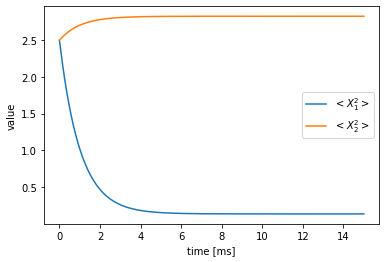

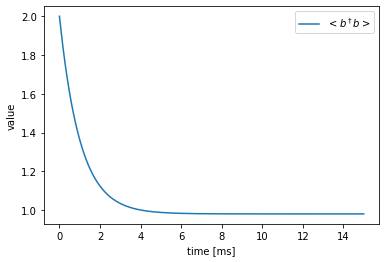

5.680746329422676


In [331]:
# plot squeezed and antisqueezed quadratures
fig, ax = plt.subplots()
ax.plot(
    guess_dynamics.times * 1000,
    np.array(guess_dynamics.expect[0]),
    label=r'$<X_1^2>$',
)
ax.plot(
    guess_dynamics.times * 1000,
    np.array(guess_dynamics.expect[1]),
    label=r'$<X_2^2>$',
)
ax.legend()
ax.set_xlabel('time [ms]')
ax.set_ylabel('value')
plt.show(fig)

# plot mechanical phonon number
fig, ax = plt.subplots()
ax.plot(
    guess_dynamics.times * 1000,
    np.array(guess_dynamics.expect[2]),
    label=r'$<b^\dagger b>$',
)
ax.legend()
ax.set_xlabel('time [ms]')
ax.set_ylabel('value')
plt.show(fig)

print(10*np.log10((qt.fock_dm(Nb, 0)*X1m**2).tr()/guess_dynamics.expect[0][-1]))

# Define optimization objective 

We re-run the above simulation and extract the final state as our target state. We then populate a `krotov` objectives object.

In [332]:
guess_dynamics_states = qt.mesolve(L, rho0 = rho_init, tlist=tlist)

#define final state and objective function
rho_final = guess_dynamics_states.states[-1]
objectives = [krotov.Objective(initial_state = rho_init, target = rho_final, H=L)]

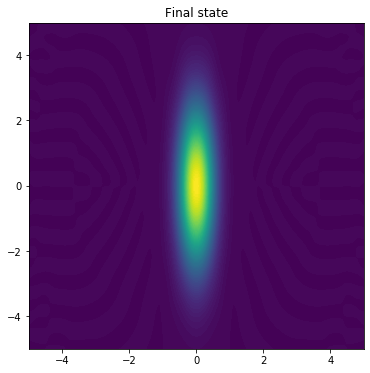

In [341]:
xvec = np.linspace(-5,5,200)

W_final = qt.wigner(rho_final, xvec, xvec)

# plot the results

fig, ax = plt.subplots(figsize = (6,6))
cont0 = ax.contourf(xvec, xvec, W_final, 100)
lbl0 = ax.set_title("Final state")
plt.show()

# Define Krotov step sizes

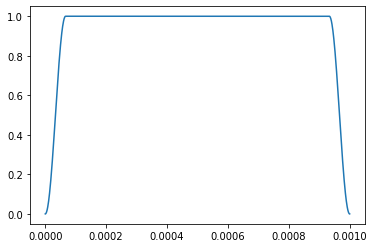

In [342]:
# define shape function
def S(t):
    """Shape function for the field update"""
    return krotov.shapes.flattop(
        t, t_start=0, t_stop=1.5e-2, t_rise=1e-3, t_fall=1e-3, func='sinsq'
    )


# define new time list
tlist2 = np.linspace(0,1e-3,1000) # time in seconds

# plot envelope
shape = np.zeros_like(tlist2)

for ii in range(len(tlist2)):
    shape[ii] = S(tlist[ii])
    
plt.plot(tlist2, shape)

# define global update step

lambda_set = 5

# define pulse options dictionary
pulse_options = {
    L[0][1]: dict(lambda_a=lambda_set, update_shape=S),
    L[1][1]: dict(lambda_a=lambda_set, update_shape=S)
}

# Define $\chi$-constructor function

Only care about mechanical state

In [308]:
# def chis_hs_reduced(fw_states_T, objectives, tau_vals):
#     """
#     Calculate chis for the chosen functional
    
#     fw_states_T: list of forward-propagating states at time T
#     objectives: krotov.Objective object, passed autmatically by krotov.optimize_pulses
#     tau_values: list of complex overlaps between fw_states_T and targets in objectives variable,
#                 given by inner product in Hilbert space or Hilbert-Schmidt product in Liouville
#                 space (space of density matrices)
                
#     Returns:
#         list containing the chi states
#     """
    
#     # reduced forward propagated state
#     fw_state = fw_states_T[0].ptrace(1)
    
#     # reduced objective state
#     objective_state = objectives[0].target.ptrace(1)
    
#     # chi state
#     chi = qt.tensor(qt.identity(Nd),(objective_state - fw_state)/2)
    
#     return [chi]

# def J_T_hs_reduced(fw_states_T, objectives, tau_vals=None, **kwargs):
#     """
#     Calculate chis for the chosen functional
    
#     fw_states_T: list of forward-propagating states at time T
#     objectives: krotov.Objective object, passed auutmatically by krotov.optimize_pulses
#     tau_values: list of complex overlaps between fw_states_T and targets in objectives variable,
#                 given by inner product in Hilbert space or Hilbert-Schmidt product in Liouville
#                 space (space of density matrices)
                
#     The `kwargs` are ignored, allowing the function to be used in an
#     `info_hook`.
                
#     Returns:
#         (float) cost function value between 0 and 1
#     """
#     # reduced forward propagated state
#     fw_state = fw_states_T[0].ptrace(1)
    
#     # reduced objective state
#     objective_state = objectives[0].target.ptrace(1)
    
#     # calculate Hilbert-schmidt distance b/w reduced density matrices
#     hs = 'fro'  # qutip's name for HS-norm for density matrices
#     dist = (fw_state.norm(hs) ** 2 + objective_state.norm(hs) ** 2 - 2 * _overlap(fw_state, objective_state).real)/2
    
#     return dist

# Optimizing the pulse sequence

In [343]:
# perform optimization
opt_result = krotov.optimize_pulses(
    objectives,
    pulse_options=pulse_options,
    tlist=tlist2,
    propagator=krotov.propagators.DensityMatrixODEPropagator(),
    chi_constructor=krotov.functionals.chis_hs,
    info_hook=krotov.info_hooks.print_table(
        J_T=krotov.functionals.J_T_hs),
#     check_convergence=krotov.convergence.Or(
#         krotov.convergence.value_below('1e-3', name='J_T'),
#        krotov.convergence.check_monotonic_error,
#     )
#     info_hook=krotov.info_hooks.chain(
#         krotov.info_hooks.print_debug_information
#     ),
    iter_stop = 4
)

iter.      J_T   ∑∫gₐ(t)dt          J       ΔJ_T         ΔJ  secs
0     1.60e-01    0.00e+00   1.60e-01        n/a        n/a    12
1     1.60e-01    5.92e-10   1.60e-01   1.31e-08   1.37e-08    34 **
2     1.60e-01    5.92e-10   1.60e-01  -3.45e-08  -3.39e-08    39
3     1.60e-01    5.92e-10   1.60e-01   6.55e-08   6.60e-08    34 **
4     1.60e-01    5.92e-10   1.60e-01  -4.51e-08  -4.45e-08    36


In [344]:
optimized_dynamics = opt_result.optimized_objectives[0].mesolve(
    tlist2, e_ops=[proj0,proj1, proj2]
)

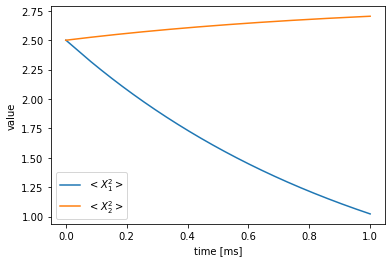

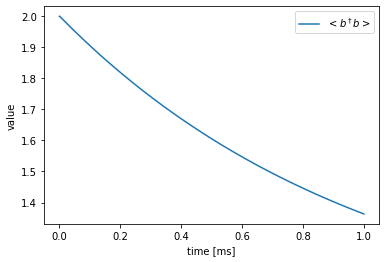

In [345]:
# plot squeezed and antisqueezed quadratures
fig, ax = plt.subplots()
ax.plot(
    optimized_dynamics.times * 1000,
    np.array(optimized_dynamics.expect[0]),
    label=r'$<X_1^2>$',
)
ax.plot(
    optimized_dynamics.times * 1000,
    np.array(optimized_dynamics.expect[1]),
    label=r'$<X_2^2>$',
)
ax.legend()
ax.set_xlabel('time [ms]')
ax.set_ylabel('value')
plt.show(fig)

# plot mechanical phonon number
fig, ax = plt.subplots()
ax.plot(
    optimized_dynamics.times * 1000,
    np.array(optimized_dynamics.expect[2]),
    label=r'$<b^\dagger b>$',
)
ax.legend()
ax.set_xlabel('time [ms]')
ax.set_ylabel('value')
plt.show(fig)